# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

First lets load required modules:

In [1]:
import numpy as np
import random as rn
from dotenv import load_dotenv
import os
from skimage import io
from skimage.transform import resize, rotate
from skimage.util import pad
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model, Sequence

import itertools

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate, Reshape, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import confusion_matrix
# import tensorflow as tf

import datetime
import time
import threading
load_dotenv()

Using TensorFlow backend.


True

 Then seed the random number generators to make results reproducible:

In [2]:
rn.seed(42)
np.random.seed(42)

Then load environmental variables that point to the location of folders on this instance.

In [3]:
datafolder = os.getenv("DATAFOLDER")
outputfolder = os.getenv("OUTPUTFOLDER")
imgfolder = os.path.join(datafolder, 'MiniZoo','imgs')
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

Need some way of propagating the size of the image that is invariant to rotations. I am unhappy about the rigidity of the default ImageDataGenerator. I make my own custom data generator. Next is code for custom datagenerators:

In [4]:
# From:
# https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [15]:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        with self.lock:
            return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g


class MySequence(Sequence):
    def __init__(self, batch_size, label_paths, images, get_statistics, augment_image, number_labels, size, get_label_and_image, val_split, test_split):
        self.batch_size = batch_size
        self.label_paths = label_paths
        self.images = images
        self.get_statistics = get_statistics
        self.augment_image = augment_image
        self.number_labels = number_labels
        self.size = size
        self.get_label_and_image = get_label_and_image
        self.val_split = val_split
        self.test_split = test_split
        self.seeded = False
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if not self.seeded:
            rn.seed(idx)
            np.random.seed(idx)
        output_list = []
        output_labels = []
        lab_img = self.get_label_and_image(idx)
        for random_label, random_image in lab_img:
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [1-io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        output_augmented_images = [self.augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

# See: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
# For additional possible transformations.
class MyGenerators(object):
    def __init__(self, path, val_fac=0.1, batch_size=16, validation_size=64, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.number_label_elements = {}
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        self.labels_to_classify = []
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
        self.test_split = int(val_fac*min(self.label_len.values()))
        self.val_split = int(2*val_fac*min(self.label_len.values()))
        self.val_steps = int(self.number_labels*(self.val_split-self.test_split)/self.batch_size)
        self.val_log = []
        self.training_log = []

    def make_square(self, image, mode='constant'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        else:
            max_dim = 224
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image, pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        angle = np.random.randint(0, 359 + 1)
        image = rotate(image, angle, resize=True, mode='constant', cval=0)
        image = self.make_square(image, mode='constant')
        #if(np.random.choice([True, False])):
        #    image = elastic_transform(image, 224, 19)
        return image

    def get_statistics(self, image):
        return (max(image.shape)/1024.0, min(image.shape)/1024.0, np.sum(image==255)/(1.0*np.product(image.shape)))

    def base_generator(self, augment_image, get_random_label_and_image):
        output_list = []
        output_labels = []
        while not len(output_list) == self.batch_size:
            random_label, random_image = next(get_random_label_and_image)
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [1-io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        output_augmented_images = [augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

    def training_image_selector(self, idx):
        #while True:
        lab_img = []
        for i in range(self.batch_size):
            random_label = np.random.choice( self.number_labels)
            random_image = np.random.choice(range(self.val_split, self.label_len[random_label]))
            lab_img.append((random_label, random_image))
        return lab_img
    
    #@threadsafe_generator
    #def training_generator(self):        
    #    it = self.training_image_selector()
    #    while True:
    #        yield self.base_generator(self.augment_image, it)
    
    def training_generator(self):
        return MySequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths, 
                          images = self.images,
                          get_statistics=self.get_statistics, 
                          augment_image=self.augment_image, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(min(self.label_len.values()) - self.val_split)/self.batch_size), 
                          get_label_and_image=self.training_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split)

    def val_image_selector(self, idx):
        #while True:
        #random_label = np.random.choice(self.number_labels)
        #random_image = np.random.choice(range(self.test_split, self.val_split))
        #return (random_label, random_image)
        lab_img = []
        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            num_img_per_label = self.val_split-self.test_split
            i = i % int(self.number_labels*(num_img_per_label))
            lab = int(i/num_img_per_label)
            img = i - lab*num_img_per_label
            lab_img.append((lab, img+self.test_split))
        
        return lab_img
        #tot = self.number_label*(self.val_split - self.test_split)
                
            
        #while True:
        #    for random_label in range(self.number_labels):
        #        for random_image in range(self.test_split, self.val_split):
        #             yield (random_label, random_image)

    def validation_generator(self):
        return MySequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths,
                          get_statistics=self.get_statistics, 
                          images = self.images,
                          augment_image=self.make_square, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(self.val_split-self.test_split)/self.batch_size), 
                          get_label_and_image=self.val_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split)
        #it = self.val_image_selector()
        #while True:
        #    yield self.base_generator(self.make_square, it)    
    
    def test_image_selector(self,idx):
        while True:
            for random_label in range(self.number_labels):
                for random_image in range(self.test_split):
                    yield (random_label, random_image)
    
    @threadsafe_generator
    def test_generator(self):
        it = self.test_image_selector()
        while True:
            yield self.base_generator(self.make_square, it)    


class MySecondGenerators(MyGenerators):
    def make_square(self, image, mode='symmetric'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        else:
            max_dim = 224
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image, pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        angle = np.random.choice([0,np.random.randint(0, 359 + 1)])
        image = rotate(image, angle, resize=True, mode='constant', cval=0)
        image = self.make_square(image, mode='symmetric')
        #if(np.random.choice([True, False])):
        #    image = elastic_transform(image, 224, 19)
        return image
            
@threadsafe_generator            
def make_image_generator(gen):
    while True:
        res = next(gen)
        yield res[0][0], res[1]

@threadsafe_generator
def make_stat_generator(gen):
    while True:
        res = next(gen)
        yield res[0][1], res[1]


Next is code to visualize the data provided by the custom data generators:

In [6]:

def visualize_generator(dategen):
    train_gen = dategen.training_generator()
    validation_gen = dategen.validation_generator()

    NUMBER_LABELS = dategen.number_labels

    print("Number of validation images per class: ", dategen.val_split-dategen.test_split)
    print("Number of steps needed to go through all validation images: ", dategen.val_steps)
    
    print("Class distribution")
    plt.bar(dategen.label_len.keys(), dategen.label_len.values())
    plt.show()
    
    print("Visualize images of training generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = train_gen[i]
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show()  
    
    print("Visualize images of validation generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = validation_gen[i]
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show() 


Lets instanciate a generator and have a look at the data is provides:

Number of validation images per class:  105
Number of steps needed to go through all validation images:  525
Class distribution


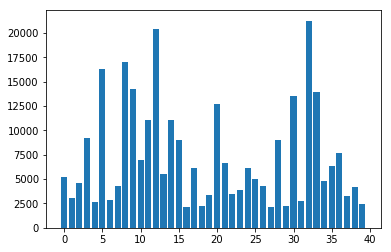

Visualize images of training generator, a quick check to see that input data is still sane:


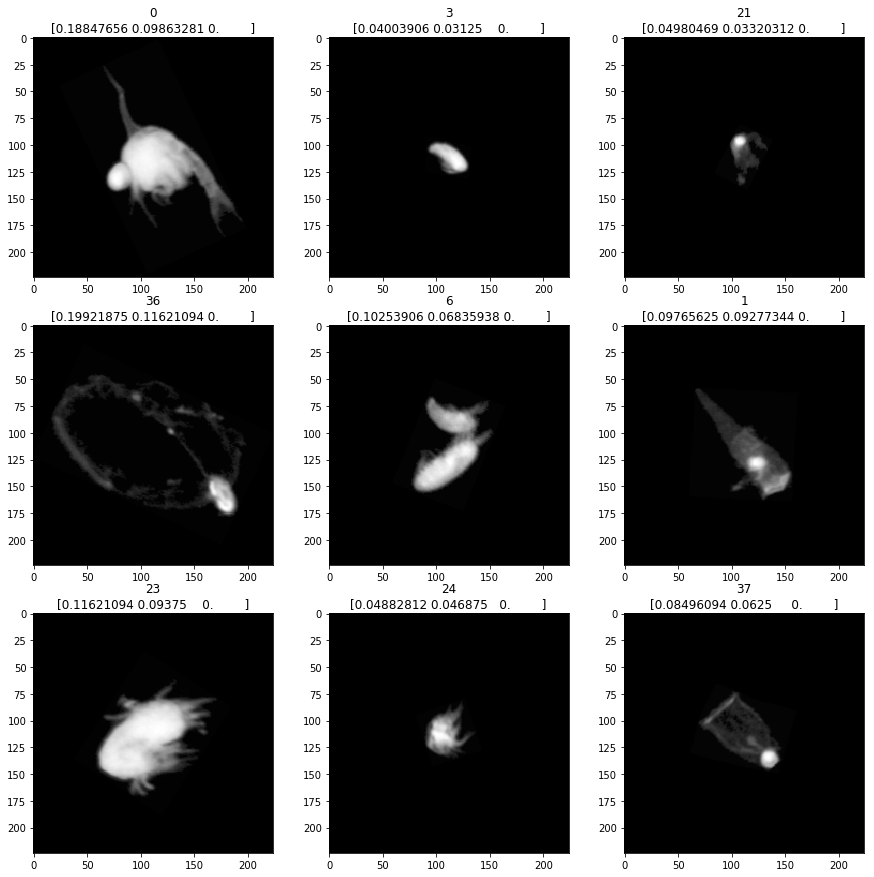

Visualize images of validation generator, a quick check to see that input data is still sane:


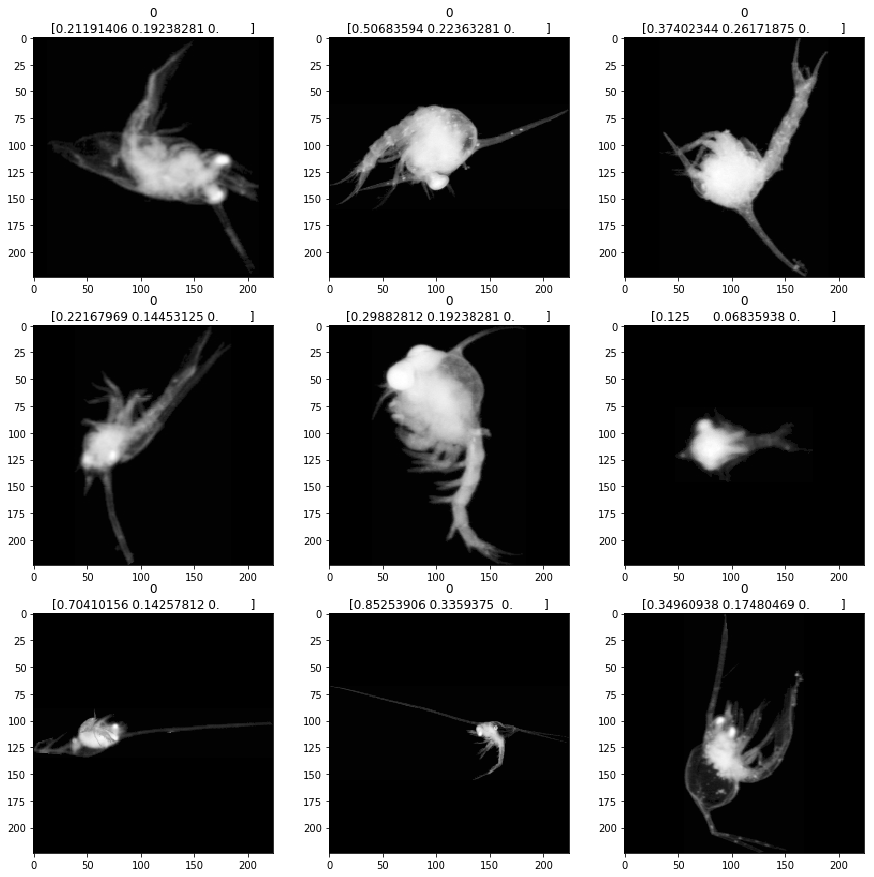

In [16]:
EPOCHS = 1
BATCH_SIZE = 8
#dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
dategen = MyGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.05)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

In [8]:
#EPOCHS = 1
#BATCH_SIZE = 8
#dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
#dategen = MyGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
#train_gen = dategen.training_generator()
#validation_gen = dategen.validation_generator()
#NUMBER_LABELS = dategen.number_labels
#visualize_generator(dategen)

Then lets add a helper function to train and save models:

In [9]:
def fit_and_save_model(name, model, train_gen, validation_gen, 
                       steps_per_epoch = 10, validation_steps=10, epochs=10, img_input=True, patience=10, load_old_weights=False):
    modeloutputfolder = os.path.join(outputfolder, name)
    if not os.path.exists(modeloutputfolder):
        os.makedirs(modeloutputfolder)
        
    if load_old_weights and os.path.exists(os.path.join(modeloutputfolder,'model_fitted.h5')):
        model = load_model(os.path.join(modeloutputfolder,'model_fitted.h5'))
    
    cbs=[ModelCheckpoint(filepath=os.path.join(modeloutputfolder,'model_fitted.h5'), verbose=1, save_best_only=True),
         #EarlyStopping(monitor='val_loss', patience=patience),
         CSVLogger(os.path.join(modeloutputfolder,'model_history.csv'), separator=',', append=False)]
         
    start_time = time.time()
    history = model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_gen,
                             validation_steps=validation_steps,
                             epochs=epochs, 
                             callbacks=cbs,
                             use_multiprocessing=True,
                             workers=8)
    end_time = time.time()
    
    
    plot_model(model, 
           to_file=os.path.join(modeloutputfolder,'model_visualized.png'),
           show_shapes=True,
           show_layer_names=True)
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig(os.path.join(modeloutputfolder,'model_history.png'))
    plt.show()
    
    score = model.evaluate_generator(validation_gen, steps=validation_steps)
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    
    with open(os.path.join(modeloutputfolder,'model_score.txt'), 'w+') as f:
        f.write(summary)

    print("It has the following confusion matrix:")
    img_vals = []
    stat_vals = []
    y_vals = []
    for i in range(validation_steps):
        x, y = validation_gen[i]
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    y_true = np.argmax(y_target, axis= 1)
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    plt.figure(figsize=(15,15))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_true+1)))
    plt.yticks(range(max(y_true+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(modeloutputfolder,'model_confusion_matrix.png'))
    plt.show()
    
    if img_input:
        print("These are examples of misclassified features:")
        plt.figure(figsize=(15,15))
        plt.suptitle("Misclassified images - Model")
        poss_indexes = np.argwhere(y_predicted-y_true != 0)
        indexes = poss_indexes[np.random.choice(len(poss_indexes), 9)]

        for i, index in enumerate(indexes.ravel()):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_validation[0][index].reshape(224,224), cmap="Greys_r")
            plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
        plt.savefig(os.path.join(modeloutputfolder,'model_misclassified_features.png'))
        plt.show()

Now lets define a simple model that analyses the image statistics:

In [10]:
inputs_stat = Input(shape=(3,))
x = Dense(16, activation='relu')(inputs_stat)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)
output_stat = Dense(NUMBER_LABELS, activation='relu')(x)
predictions_stat = Dense(NUMBER_LABELS, activation='softmax', name="output")(output_stat)
model_stat = Model(inputs=inputs_stat, outputs=predictions_stat)
model_stat.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
#fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
#                  steps_per_epoch = 20*dategen.val_steps, validation_steps=dategen.val_steps, patience=2, epochs=10, img_input=False)

And a composite model that uses a pretrained model:

In [12]:
pretrained_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
print("The lower layer is {}".format(pretrained_model.layers[-1]))
pretrained_model.trainable = False

inputs_image_make_multi_dimensional = Input(shape=(224,224,1))
make_multi_dimensional = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(inputs_image_make_multi_dimensional)
make_multi_dimensional_batchnorm = BatchNormalization()(make_multi_dimensional)
x = pretrained_model(make_multi_dimensional_batchnorm)
x = Conv2D(1, (1,1), activation='relu')(x)
outputs_pretrained = Flatten()(x)

x = Concatenate()([outputs_pretrained, output_stat])
#x = Dropout(0.2)(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

composite_model_w_pretrained_model = Model(inputs=[inputs_image_make_multi_dimensional, inputs_stat], outputs=predictions)

composite_model_w_pretrained_model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

The lower layer is <keras.layers.advanced_activations.ReLU object at 0x7f541bdc6ef0>


Lets get training. Start with the network that looks at the image statistics:

Now lets train the model with rms optimizer having the pretrained network untrainable.

Epoch 1/6
591/591 [==============================] - 68s 115ms/step - loss: 3.2609 - acc: 0.0859 - val_loss: 3.1251 - val_acc: 0.0993

Epoch 00001: val_loss improved from inf to 3.12511, saving model to ../output/composite_model_w_pretrained_model/model_fitted.h5
Epoch 2/6
591/591 [==============================] - 63s 107ms/step - loss: 2.9990 - acc: 0.1269 - val_loss: 2.9980 - val_acc: 0.1074

Epoch 00002: val_loss improved from 3.12511 to 2.99802, saving model to ../output/composite_model_w_pretrained_model/model_fitted.h5
Epoch 3/6
591/591 [==============================] - 59s 101ms/step - loss: 2.9481 - acc: 0.1396 - val_loss: 3.0015 - val_acc: 0.0986

Epoch 00003: val_loss did not improve from 2.99802
Epoch 4/6
591/591 [==============================] - 61s 103ms/step - loss: 2.9128 - acc: 0.1557 - val_loss: 2.9785 - val_acc: 0.1245

Epoch 00004: val_loss improved from 2.99802 to 2.97854, saving model to ../output/composite_model_w_pretrained_model/model_fitted.h5
Epoch 5/6
591/

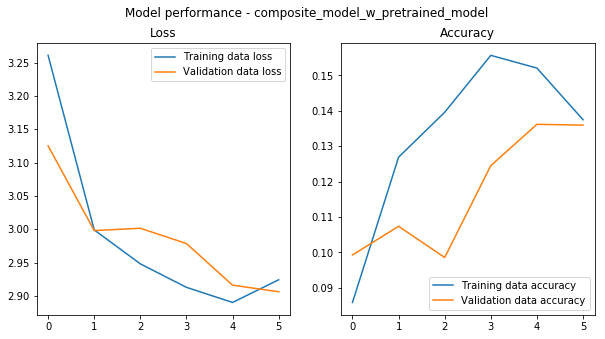

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


It has the following performance:
Validation loss: 2.906225153151013
Validation accuracy: 0.13595238095238096
Training time: 379.25614953041077
It has the following confusion matrix:


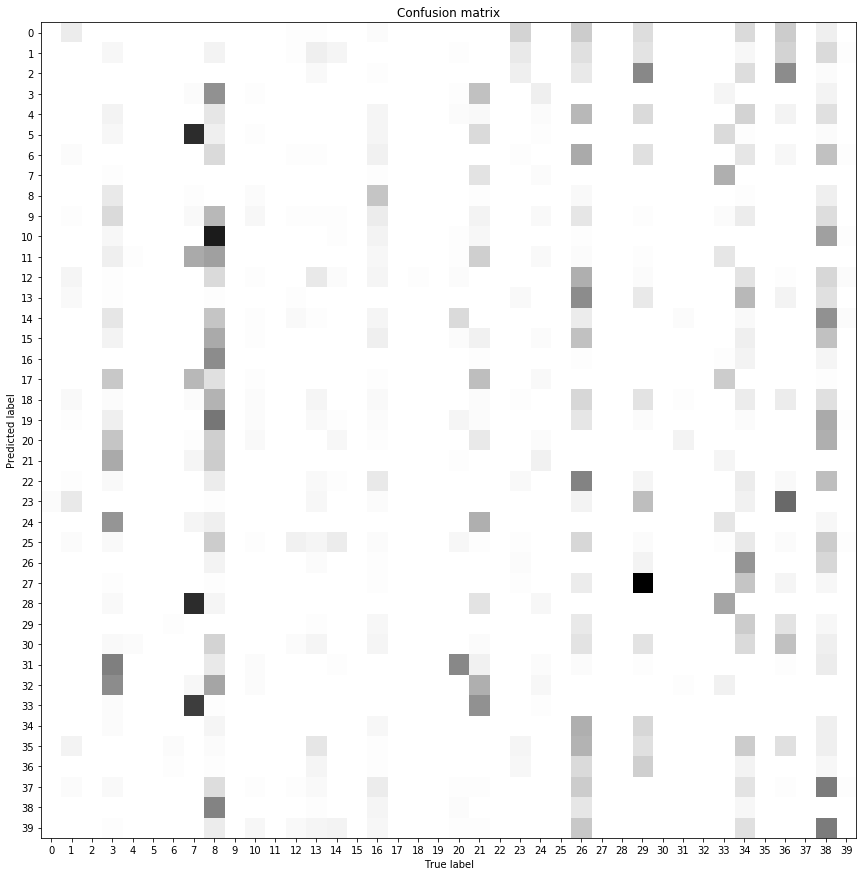

These are examples of misclassified features:


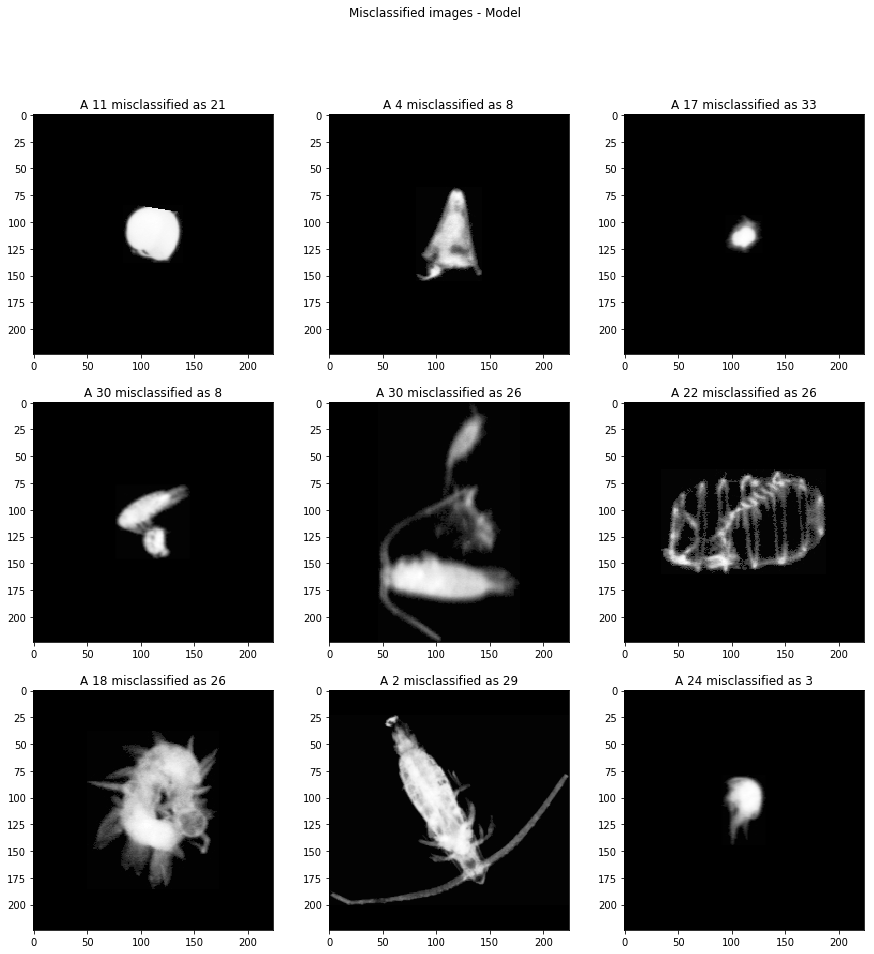

In [13]:
fit_and_save_model("composite_model_w_pretrained_model", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = len(train_gen)//16, validation_steps=len(validation_gen), patience=2, epochs=6*16) #Best was: 0.1357

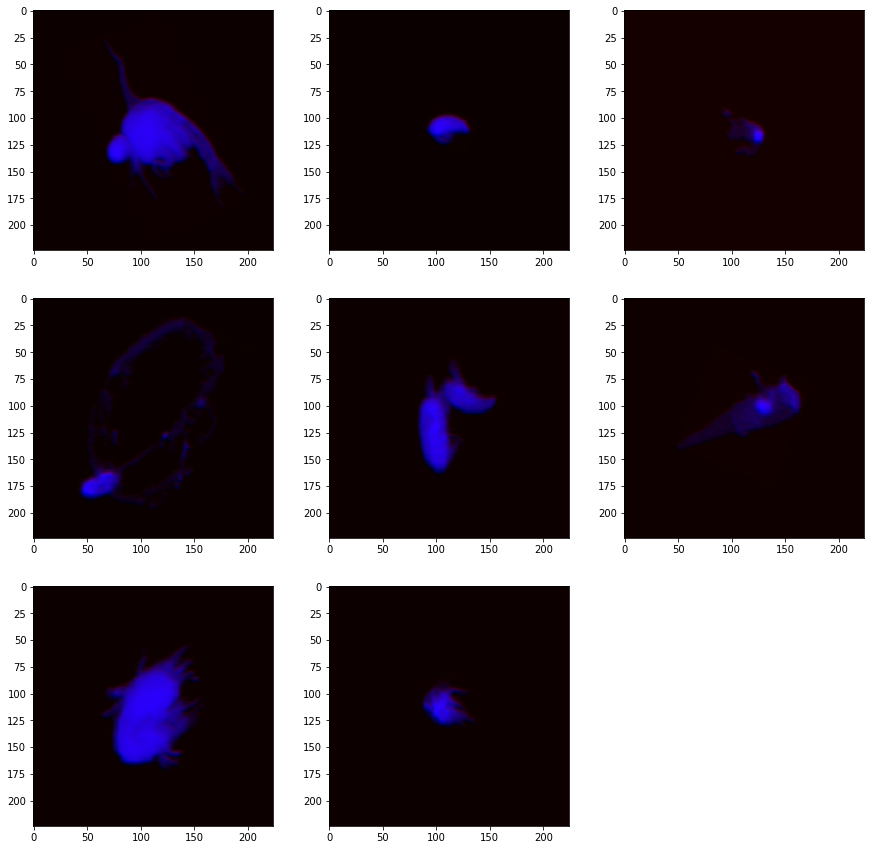

In [14]:
multi_dimensional_model = Model(inputs=inputs_image_make_multi_dimensional, outputs=make_multi_dimensional)
test = multi_dimensional_model.predict(train_gen[0][0][0], steps=1)
plt.figure(figsize=(15,15))
j = 1
for i in test:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i/np.max(i))
    j += 1
plt.show()

Then lets set the pretrained network trainable and train the model using sgd optimizer

In [17]:
pretrained_model.trainable = True
composite_model_w_pretrained_model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
fit_and_save_model("composite_model_w_pretrained_model_full", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = len(train_gen)//16, validation_steps=len(validation_gen), epochs=6*16)

Epoch 1/96
591/591 [==============================] - 125s 212ms/step - loss: 2.9584 - acc: 0.1248 - val_loss: 2.8878 - val_acc: 0.1426

Epoch 00001: val_loss improved from inf to 2.88776, saving model to ../output/composite_model_w_pretrained_model_full/model_fitted.h5
Epoch 2/96
591/591 [==============================] - 116s 196ms/step - loss: 2.8809 - acc: 0.1398 - val_loss: 2.9028 - val_acc: 0.1333

Epoch 00002: val_loss did not improve from 2.88776
Epoch 3/96
 32/591 [>.............................] - ETA: 1:54 - loss: 2.8679 - acc: 0.1484

Process ForkPoolWorker-93:
Process ForkPoolWorker-96:
Process ForkPoolWorker-70:
Process ForkPoolWorker-76:
Process ForkPoolWorker-94:
Process ForkPoolWorker-66:
Process ForkPoolWorker-90:
Process ForkPoolWorker-89:
Process ForkPoolWorker-95:
Process ForkPoolWorker-72:
Process ForkPoolWorker-92:
Process ForkPoolWorker-91:
Process ForkPoolWorker-67:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-79:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-71:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap


KeyboardInterrupt: 

The one dimensional input data is made 3d by a conv2d layer with 3 filters. The 3 channel representation looks like the following:

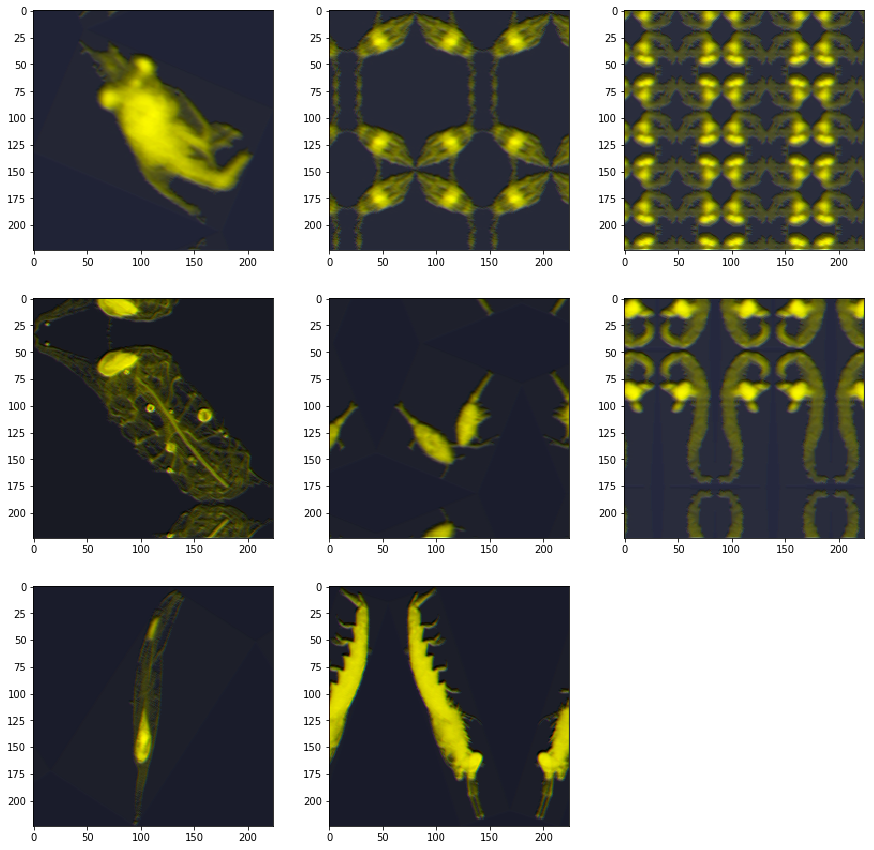

In [22]:
multi_dimensional_model = Model(inputs=inputs_image_make_multi_dimensional, outputs=make_multi_dimensional)
test = multi_dimensional_model.predict(train_gen[0][0][0], steps=1)
plt.figure(figsize=(15,15))
j = 1
for i in test:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i/np.max(i))
    j += 1
plt.show()  

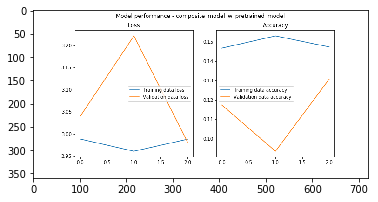

array([[[-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        ...,
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643]],

       [[-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        ...,
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643]],

       [[-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        ...,
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643],
        [-0.25128826, -0.16570854, -0.14027643]],

       ...,

       [[-0.25128826, -0.16570854, -0.14027643],
        [-0

array([[[  0.      ,   0.      ,   6.35605 ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[  0.      ,   0.      ,  74.30496 ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[  0.      ,   0.      ,  74.30496 ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       ...,

       [[  0.      ,   0.      ,  74.30496 ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,  

dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

fit_and_save_model("composite_model_w_pretrained_model", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

In [ ]:
#fit_and_save_model("composite_model", composite_model, train_gen, validation_gen,
#                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

In [ ]:
#fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
#                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS, img_input=False)

In [ ]:
#fit_and_save_model("model_images", model_images, make_image_generator(train_gen), make_image_generator(validation_gen),
#                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)